## Machine Learning Solar Flare Forecasting 

In this notebook an overview of the dataset that is used for a ML forecasting project is project.

The data used here is from `AR_flare_ml_23_24.csv` which consists of compiled AR data from daily NOAA SRS files, and then solar flare data which is compiled from the NOAA SWPC daily event reports. 

* script to create `AR_flare_ml_23_24.csv` is `making_ml_df_sc23-24.py`.
* the swpc flare data (`swpc_flarelist_19960731_20181231.csv`) is generated in `generate_flarelist.py` located in `/flare_analysis/goes_flare_list/`
* the NOAA active region data is `SRS_data_new_19960101_20181231.csv` that is created by `new_read_srs.py ` located in `/flare_analysis/AR_analysis/`.



In [140]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import datetime
import time
import warnings
warnings.filterwarnings("ignore")

Lets read in the data to a pandas DataFrame

In [141]:
data = pd.read_csv("AR_flare_ml_23_24.csv")

In [142]:
# lets just check there are no nans
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
print(np.sum(row_has_NaN))

0


In [143]:
data = data[(data["AR issue_date"] > "1996-08-06")]
data.reset_index(inplace=True, drop=True)

In [144]:
data["zurich1"] = data["McIntosh"].map(lambda x: x[0])
data["penumbral1"] = data["McIntosh"].map(lambda x: x[1])
data["compact1"] = data["McIntosh"].map(lambda x: x[2])

In [145]:
data.head()

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,LOCATION,C,M,X,C+,M+,X+,zurich1,penumbral1,compact1
0,1996-08-06 00:30,7981,259,220,CSO,8,-9,46,10.0,BETA,S09W46,0.0,0.0,0.0,0.0,0.0,0.0,C,S,O
1,1996-08-07 00:30,7981,260,140,CSO,7,-10,60,3.0,BETA,S10W60,0.0,0.0,0.0,0.0,0.0,0.0,C,S,O
2,1996-08-08 00:30,7981,260,130,HSX,2,-11,73,1.0,ALPHA,S11W73,0.0,0.0,0.0,0.0,0.0,0.0,H,S,X
3,1996-08-08 00:30,7982,165,10,BXO,3,11,-22,5.0,BETA,N11E22,0.0,0.0,0.0,0.0,0.0,0.0,B,X,O
4,1996-08-09 00:30,7981,263,120,HSX,2,-11,89,1.0,ALPHA,S11W89,0.0,0.0,0.0,0.0,0.0,0.0,H,S,X


## Lets compare parameters and how the compare with flaring/non-flaring regionsm

In [7]:
ar_w_flare = data[data["C+"]>0]
ar_no_flare = data[data["C+"]==0]

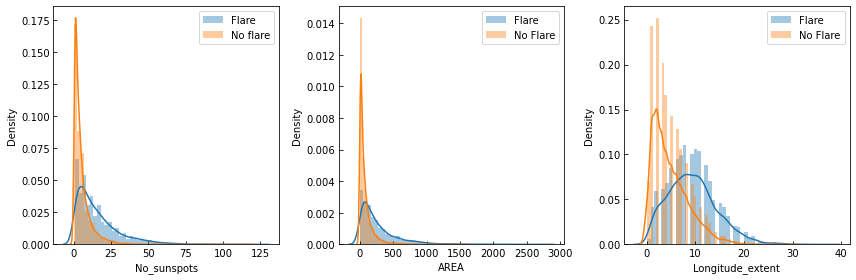

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(ar_w_flare["No_sunspots"], ax=ax[0], label="Flare")
sns.distplot(ar_no_flare["No_sunspots"], ax=ax[0], label="No flare")

sns.distplot(ar_w_flare["AREA"], ax=ax[1], label="Flare")
sns.distplot(ar_no_flare["AREA"], ax=ax[1], label="No Flare")

sns.distplot(ar_w_flare["Longitude_extent"], ax=ax[2], label="Flare")
sns.distplot(ar_no_flare["Longitude_extent"], ax=ax[2], label="No Flare")

for a in ax:
    a.tick_params(which="both", direction="in")
    a.legend(loc="upper right")
    
plt.tight_layout()

Text(0, 0.5, 'Normalized % of cases')

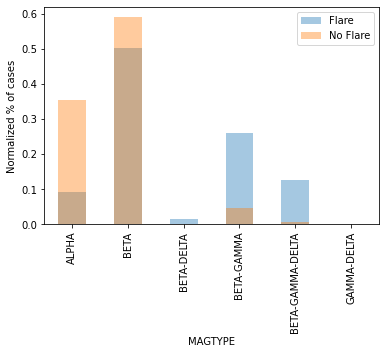

In [9]:
fig, ax = plt.subplots(1)
((ar_w_flare.groupby(["MAGTYPE"])["C"].count())/len(ar_w_flare)).plot.bar(ax=ax, 
                                                                          alpha=0.4, label="Flare")
((ar_no_flare.groupby(["MAGTYPE"])["C"].count())/len(ar_no_flare)).plot.bar(ax=ax, color="tab:orange", 
                                                                            alpha=0.4, label="No Flare")
ax.legend()
ax.set_ylabel("Normalized % of cases")

Text(0, 0.5, 'Normalized % of cases')

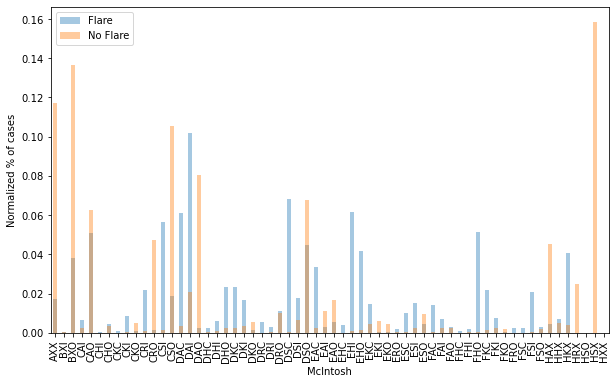

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
((ar_w_flare.groupby(["McIntosh"])["C"].count())/len(ar_w_flare)).plot.bar(ax=ax, 
                                                                          alpha=0.4, label="Flare")
((ar_no_flare.groupby(["McIntosh"])["C"].count())/len(ar_no_flare)).plot.bar(ax=ax, color="tab:orange", 
                                                                            alpha=0.4, label="No Flare")
ax.legend()
ax.set_ylabel("Normalized % of cases")

In [11]:
len(data[data["MAGTYPE"].isin(["GAMMA-DELTA"])])

10

## Lets add in some more parameters that will be of importance

These include the previous AR/flare properties of each day. Lets add in if that AR flared the day previous, and if what the active region McIntosh and Hale class was the day before, and the area (i.e. has it grown it shrunk?)

In [12]:
t1 = time.time()
prev_area, prev_mcint, prev_mag, prev_flare, z2, p2, c2 = [], [], [], [], [], [], []
for i in range(len(data)):

    test = data.iloc[i]
    previous_day = (pd.to_datetime(test["AR issue_date"])-datetime.timedelta(days=1)).strftime("%Y-%m-%d 00:30")
    ar_match = test["noaa_ar"]
    data_prev = data[(data["AR issue_date"].isin([previous_day]))&(data["noaa_ar"].isin([ar_match]))]

    if len(data_prev)==0:
        prev_area.append(np.nan), prev_mcint.append(np.nan), prev_mag.append(np.nan), prev_flare.append(np.nan), 
        z2.append(np.nan), p2.append(np.nan), c2.append(np.nan)
    else:
        prev_area.append(data_prev["AREA"].values[0]), prev_mcint.append(data_prev["McIntosh"].values[0]), 
        prev_mag.append(data_prev["MAGTYPE"].values[0]), prev_flare.append(data_prev["C+"].values[0]), 
        z2.append(data_prev["zurich1"].values[0]), p2.append(data_prev["penumbral1"].values[0]), c2.append(data_prev["compact1"].values[0])
t2 = time.time()
print(t2 - t1)


75.1013720035553


In [13]:
data["pre_area"] = prev_area
data["pre_mcint"] = prev_mcint
data["pre_mag"] = prev_mag
data["pre_flare"] = prev_flare

data["zurich2"] = z2
data["penumbral2"] = p2
data["compact2"] = c2

In [139]:
data.head(3)

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,...,zurich1,penumbral1,compact1,pre_area,pre_mcint,pre_mag,pre_flare,zurich2,penumbral2,compact2
0,1996-08-06 00:30,7981,259,220,CSO,8,-9,46,10.0,BETA,...,C,S,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-08-07 00:30,7981,260,140,CSO,7,-10,60,3.0,BETA,...,C,S,O,220.0,CSO,BETA,0.0,C,S,O
2,1996-08-08 00:30,7981,260,130,HSX,2,-11,73,1.0,ALPHA,...,H,S,X,140.0,CSO,BETA,0.0,C,S,O


In [14]:
# lets just check there are no nans
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
print(np.sum(row_has_NaN))

5270


In [15]:
np.sum(row_has_NaN)/len(data)

0.1572617946345976

In [16]:
rows_with_NaN

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,...,zurich1,penumbral1,compact1,pre_area,pre_mcint,pre_mag,pre_flare,zurich2,penumbral2,compact2
0,1996-08-06 00:30,7981,259,220,CSO,8,-9,46,10.0,BETA,...,C,S,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-08-08 00:30,7982,165,10,BXO,3,11,-22,5.0,BETA,...,B,X,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1996-08-11 00:30,7983,134,10,AXX,2,26,-13,3.0,ALPHA,...,A,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1996-08-15 00:30,7984,71,10,BXO,4,30,-23,6.0,BETA,...,B,X,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,1996-08-20 00:30,7985,42,10,AXX,2,10,14,3.0,ALPHA,...,A,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33496,2018-11-16 00:30,12727,111,20,CRO,4,1,17,3.0,BETA,...,C,R,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33501,2018-11-25 00:30,12728,339,20,BXO,3,6,3,4.0,BETA,...,B,X,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33503,2018-12-06 00:30,12729,228,30,CRO,4,-5,38,6.0,BETA,...,C,R,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33508,2018-12-12 00:30,12730,94,10,AXX,2,8,-17,1.0,ALPHA,...,A,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
100*(rows_with_NaN["MAGTYPE"].value_counts()/data["MAGTYPE"].value_counts())

ALPHA               18.830089
BETA                17.109237
BETA-DELTA           1.212121
BETA-GAMMA           1.753180
BETA-GAMMA-DELTA     0.603622
GAMMA                     NaN
GAMMA-DELTA               NaN
Name: MAGTYPE, dtype: float64

In [18]:
data["MAGTYPE"].value_counts()

BETA                19206
ALPHA               10223
BETA-GAMMA           2909
BETA-GAMMA-DELTA      994
BETA-DELTA            165
GAMMA-DELTA            10
GAMMA                   4
Name: MAGTYPE, dtype: int64

(array([1.92522244e-06, 0.00000000e+00, 3.85044487e-05, 1.93869899e-03,
        2.05363477e-02, 1.11893928e-02, 2.34607606e-02, 7.05594023e-03,
        2.92633810e-04, 1.92522244e-06]),
 array([-89. , -73.5, -58. , -42.5, -27. , -11.5,   4. ,  19.5,  35. ,
         50.5,  66. ]),
 <BarContainer object of 10 artists>)

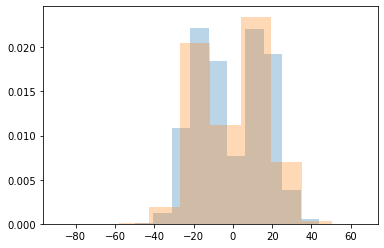

In [19]:
plt.hist(rows_with_NaN["Latitude"], alpha=0.3, density=True)
plt.hist(data["Latitude"], alpha=0.3, density=True)

(array([0.00172147, 0.00495745, 0.00553341, 0.00653453, 0.00666287,
        0.00718108, 0.00665004, 0.00598905, 0.00544678, 0.00308677]),
 array([-87. , -68.4, -49.8, -31.2, -12.6,   6. ,  24.6,  43.2,  61.8,
         80.4,  99. ]),
 <BarContainer object of 10 artists>)

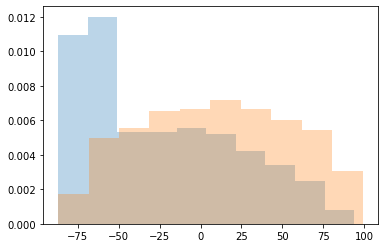

In [20]:
plt.hist(rows_with_NaN["Longitude"], alpha=0.3, density=True)
plt.hist(data["Longitude"], alpha=0.3, density=True)

In [21]:
beta_gamma_nan = rows_with_NaN[rows_with_NaN["MAGTYPE"].isin(["BETA-GAMMA-DELTA"])]
beta_gamma_data = data[data["MAGTYPE"].isin(["BETA-GAMMA-DELTA"])]

In [22]:
beta_gamma_nan

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,...,zurich1,penumbral1,compact1,pre_area,pre_mcint,pre_mag,pre_flare,zurich2,penumbral2,compact2
11178,2001-08-29 00:30,9591,293,620,FKI,26,-19,6,41.0,BETA-GAMMA-DELTA,...,F,K,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15064,2002-09-15 00:30,10114,288,470,DKC,9,-12,2,51.0,BETA-GAMMA-DELTA,...,D,K,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22984,2011-07-28 00:30,11262,66,20,DSO,10,16,38,4.0,BETA-GAMMA-DELTA,...,D,S,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24369,2012-03-22 00:30,11440,154,30,DAI,4,-26,24,5.0,BETA-GAMMA-DELTA,...,D,A,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32082,2016-02-05 00:30,12494,164,150,DAI,7,-12,-9,7.0,BETA-GAMMA-DELTA,...,D,A,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32525,2016-07-16 00:30,12567,166,190,DAC,6,5,-28,13.0,BETA-GAMMA-DELTA,...,D,A,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([0.001543  , 0.00444384, 0.00604856, 0.00820876, 0.00827048,
        0.00999864, 0.00907284, 0.00672748, 0.00450556, 0.00253052]),
 array([-70. , -53.7, -37.4, -21.1,  -4.8,  11.5,  27.8,  44.1,  60.4,
         76.7,  93. ]),
 <BarContainer object of 10 artists>)

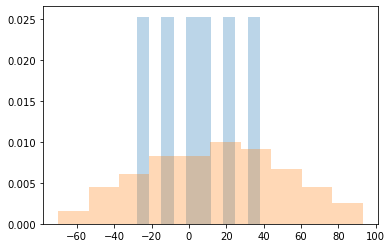

In [23]:
plt.hist(beta_gamma_nan["Longitude"], alpha=0.3, density=True)
plt.hist(beta_gamma_data["Longitude"], alpha=0.3, density=True)

## Look at only data that have prior data for evolutions

In [60]:
data_df = data[~row_has_NaN]
data_df.reset_index(inplace=True, drop=True)

data_df["binary_flare"] = data_df["C+"].map(lambda x: 1 if x>0 else 0)

In [61]:
data_df.head()

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,...,penumbral1,compact1,pre_area,pre_mcint,pre_mag,pre_flare,zurich2,penumbral2,compact2,binary_flare
0,1996-08-07 00:30,7981,260,140,CSO,7,-10,60,3.0,BETA,...,S,O,220.0,CSO,BETA,0.0,C,S,O,0
1,1996-08-08 00:30,7981,260,130,HSX,2,-11,73,1.0,ALPHA,...,S,X,140.0,CSO,BETA,0.0,C,S,O,0
2,1996-08-09 00:30,7981,263,120,HSX,2,-11,89,1.0,ALPHA,...,S,X,130.0,HSX,ALPHA,0.0,H,S,X,0
3,1996-08-09 00:30,7982,165,0,BXO,5,9,-9,3.0,BETA,...,X,O,10.0,BXO,BETA,0.0,B,X,O,0
4,1996-08-10 00:30,7982,167,20,BXO,5,10,6,10.0,BETA,...,X,O,0.0,BXO,BETA,0.0,B,X,O,0


# Flaring rates

In [26]:
test_rates = data_df.groupby(["McIntosh"])[["C", "M", "X"]].sum()

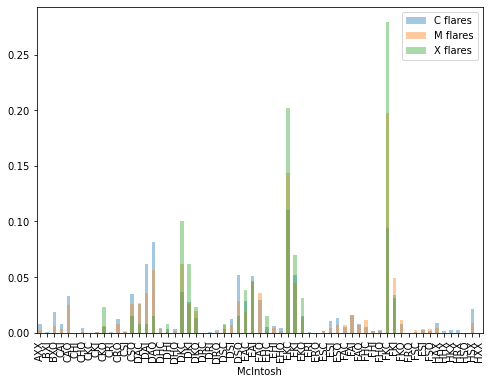

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

(test_rates["C"]/np.sum(test_rates["C"])).plot.bar(ax=ax, alpha=0.4, label="C flares")
(test_rates["M"]/np.sum(test_rates["M"])).plot.bar(ax=ax, color="tab:orange", alpha=0.4, label="M flares")
(test_rates["X"]/np.sum(test_rates["X"])).plot.bar(ax=ax, color="tab:green", alpha=0.4, label="X flares")

ax.legend()

<AxesSubplot:xlabel='McIntosh'>

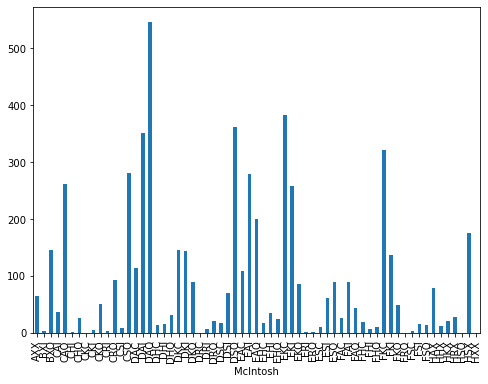

In [28]:
fig, ax = plt.subplots(figsize=(8,6 ))
data_df.groupby(["McIntosh"])["binary_flare"].sum().plot.bar()

<AxesSubplot:xlabel='compact1'>

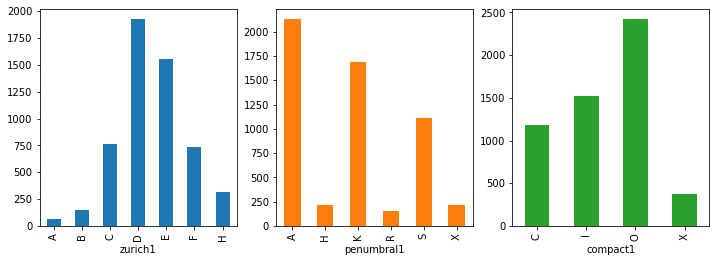

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
data_df.groupby(["zurich1"])["binary_flare"].sum().plot.bar(ax=ax[0])
data_df.groupby(["penumbral1"])["binary_flare"].sum().plot.bar(ax=ax[1], color="tab:orange")
data_df.groupby(["compact1"])["binary_flare"].sum().plot.bar(ax=ax[2], color="tab:green")

<AxesSubplot:xlabel='compact2'>

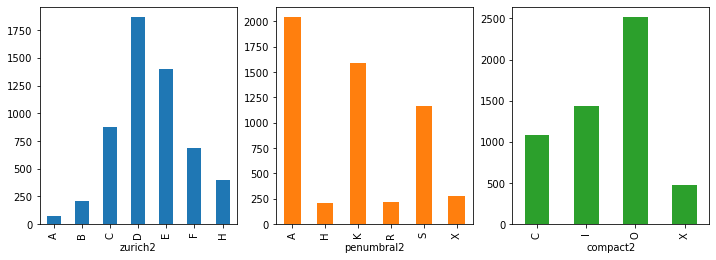

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
data_df.groupby(["zurich2"])["binary_flare"].sum().plot.bar(ax=ax[0])
data_df.groupby(["penumbral2"])["binary_flare"].sum().plot.bar(ax=ax[1], color="tab:orange")
data_df.groupby(["compact2"])["binary_flare"].sum().plot.bar(ax=ax[2], color="tab:green")

In [31]:
data_df["mcint_evol"] = data_df["McIntosh"] + data_df["pre_mcint"]

In [32]:
print(len(data_df["McIntosh"].unique()))
print(len(data_df["pre_mcint"].unique()))
print(len(data_df["mcint_evol"].unique()))

63
62
1279


<AxesSubplot:xlabel='mcint_evol'>

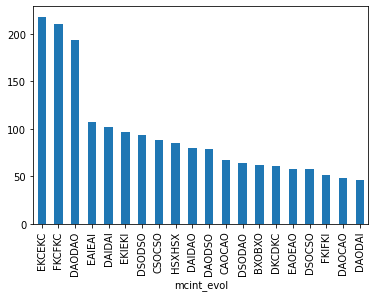

In [33]:
data_df.groupby(["mcint_evol"])["binary_flare"].sum().sort_values(ascending=False).head(20).plot.bar()

<AxesSubplot:xlabel='McIntosh'>

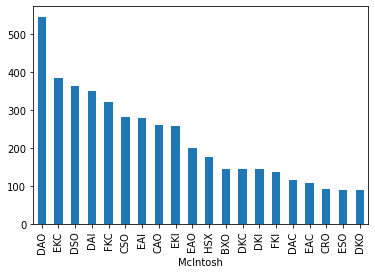

In [34]:
data_df.groupby(["McIntosh"])["binary_flare"].sum().sort_values(ascending=False).head(20).plot.bar()

In [38]:
test_rates = data_df.groupby(["MAGTYPE"])[["C", "M", "X"]].sum()

<AxesSubplot:xlabel='MAGTYPE'>

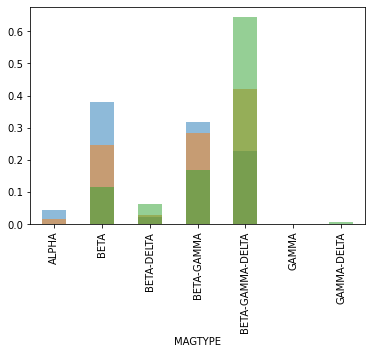

In [45]:
(test_rates["C"]/np.sum(test_rates["C"])).plot.bar(alpha=0.5)
(test_rates["M"]/np.sum(test_rates["M"])).plot.bar(alpha=0.5, color="tab:orange")
(test_rates["X"]/np.sum(test_rates["X"])).plot.bar(alpha=0.5, color="tab:green")

## Calculate Flaring Rates

In [62]:
data_df[["McIntosh", "binary_flare"]]

,McIntosh,binary_flare
0,CSO,0
1,HSX,0
2,HSX,0
3,BXO,0
4,BXO,0
...,...,...
28236,CRO,0
28237,BXO,0
28238,BXO,0
28239,BXO,0


In [63]:
data_df["McIntosh"].value_counts()

HSX    3942
CSO    2783
BXO    2632
DAO    2541
AXX    2436
       ... 
ERI       1
CKC       1
FRO       1
HSO       1
HXX       1
Name: McIntosh, Length: 63, dtype: int64

<AxesSubplot:xlabel='McIntosh'>

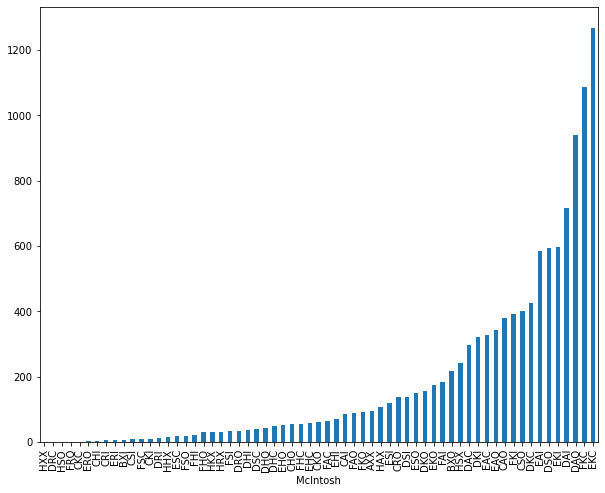

In [79]:
fig, ax = plt.subplots(figsize=(10,8))
(data_df.groupby(["McIntosh"])["C"].sum()).sort_values().plot.bar()

In [105]:
flare_rates = data.groupby(["McIntosh"])[["C", "M", "X"]].sum().reset_index()

In [106]:
total_per_group = data.groupby(["McIntosh"])["C"].count().reset_index().rename(columns={"C":"N"})

In [107]:
flare_rates["N"] = total_per_group["N"]

<AxesSubplot:xlabel='McIntosh'>

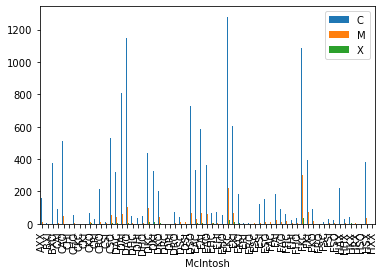

In [119]:
flare_rates.set_index("McIntosh")[["C", "M", "X"]].plot.bar()

In [132]:
flare_rates.set_index("McIntosh")[["C", "M", "X"]].div(flare_rates["N"].values, axis=0)

,C,M,X
McIntosh,,,
AXX,0.049091,0.002727,0.000000
BXI,0.368421,0.000000,0.000000
BXO,0.094636,0.004302,0.000000
CAI,0.803571,0.044643,0.000000
CAO,0.253089,0.024221,0.000000
...,...,...,...
HKX,0.299270,0.007299,0.021898
HRX,0.108815,0.002755,0.000000
HSO,0.000000,0.000000,0.000000


In [137]:
flare_rates.set_index("McIntosh")[["C", "M", "X", "N"]]

,C,M,X,N
McIntosh,,,,
AXX,162.0,9.0,0.0,3300
BXI,7.0,0.0,0.0,19
BXO,374.0,17.0,0.0,3952
CAI,90.0,5.0,0.0,112
CAO,512.0,49.0,0.0,2023
...,...,...,...,...
HKX,41.0,1.0,3.0,137
HRX,79.0,2.0,0.0,726
HSO,0.0,0.0,0.0,1
